# Whistle Detection with Continuous Kernel Convolutional Networks

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git init
    !git remote add origin https://github.com/neverorfrog/whistlenet.git
    !git pull origin main
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit install

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
pre-commit installed at .git/hooks/pre-commit


## Config Loading

In [2]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
from whistlenet.core.utils import project_root

config_path = os.path.join(project_root(), "config","whistle_config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

## Dataset Preparation

The dataset has already been uploaded to google drive. The labelling was executed by hand by using Audacity. The processing was done as such:
- Read every single .wav audio file with librosa
- Do frequency analysis
- Extract frequency associated amplitudes for every window

This is an example of frequency plot. The highlited windows are whistle samples.

<p align="left">
  <img src="../../docs/assets/image.png" alt="Alt text" width="300"/>
</p>

DATA LOADED!

N Examples: 490053
N Classes: 2
Classes: [0. 1.]
 - Class 0: 273375 (55.784782462305095)
 - Class 1: 216678 (44.2152175376949)


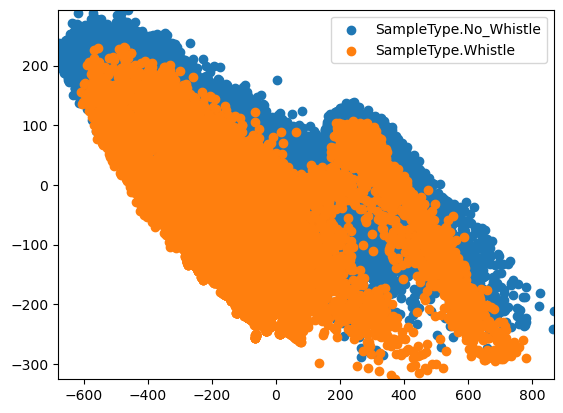

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType
import gdown

download_path = os.path.join(dataset_config.download_folder, dataset_config.name)
gdown.download_folder(
   dataset_config.drive_url, output=download_path
)

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

In [ ]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer
from whistlenet.core.hpo import hpo

hpo(whistlenet_config, dataset)               
model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(model, dataset)
trainer.test(model, dataset)

[I 2025-02-03 09:13:31,283] A new study created in memory with name: whistlenet_hpo
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type              | Params | Mode 
---------------------------------------------------------------
0  | train_f1        | BinaryF1Score     | 0      | train
1  | train_precision | BinaryPrecision   | 0      | train
2  | train_recall    | BinaryRecall      | 0      | train
3  | train_accuracy  | BinaryAccuracy    | 0      | train
4  | val_f1          | BinaryF1Score     | 0      | train
5  | val_precision   | BinaryPrecision   | 0      | train
6  | val_recall      | BinaryRecall      | 0      | train
7  | val_accuracy    | BinaryAccuracy    | 0      | train
8  | test_f1         | BinaryF1Score     | 0      | train
9  | test_precision  | BinaryPrecision   | 0      | train
10 | test_recall     | BinaryRecall      | 0      | train
11 | test_accuracy   | BinaryAccuracy    | 0

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.000722585541407192
Hidden Channels: 16
Kernel Hidden Channels: 12
Kernel Size: 33
Kernel Activation: ActivationFunction.ReLU
Epoch 0:   0%|          | 33/7658 [00:02<11:14, 11.31it/s, v_num=4]        